In [1]:
# Importazione delle librerie
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
from scipy.optimize import curve_fit
import mplhep as hep
from cycler import cycler
import matplotlib.colors as colors
import multiprocessing.pool
from scipy.optimize import approx_fprime
import pandas as pd

import matplotlib as mpl


# Impostazioni grafici
plt.style.use(hep.style.ROOT)
params = {'legend.fontsize': '12',
         'legend.loc': 'upper right',
          'legend.frameon':       'True',
          'legend.framealpha':    '0.8',      # legend patch transparency
          'legend.facecolor':     'w', # inherit from axes.facecolor; or color spec
          'legend.edgecolor':     'w',      # background patch boundary color
          'figure.figsize': (6, 4),
         'axes.labelsize': '12',
         'figure.titlesize' : '16',
         'axes.titlesize':'14',
         'xtick.labelsize':'12',
         'ytick.labelsize':'12',
         'lines.linewidth': '1',
         'text.usetex': True,
#         'axes.formatter.limits': '-5, -3',
         'axes.formatter.min_exponent': '2',
#         'axes.prop_cycle': cycler('color', 'bgrcmyk')
         'figure.subplot.left':'0.125',
         'figure.subplot.bottom':'0.125',
         'figure.subplot.right':'0.925',
         'figure.subplot.top':'0.925',
         'figure.subplot.wspace':'0.1',
         'figure.subplot.hspace':'0.1',
#         'figure.constrained_layout.use' : True
          }
plt.rcParams.update(params)
plt.rcParams['axes.prop_cycle'] = cycler(color=['b','g','r','c','m','y','k'])

In [98]:
# Definizione funzioni
def retta(x,a,b):
    # Forse non necessaria, ma comunque meglio se la definisco
    return a*x+b

def parabola(x,a,b,c):
    return a*x**2+b*x+c

def A_R(f,Q,ft,A):
    return A/np.sqrt(1+Q**2*((ft/f)**2-(f/ft)**2)**2)

def A_C(f,Q,ft,A):
    return A/np.sqrt((1-(f/ft)**2)**2+(f/(Q*ft))**2)

def phi_R(f,Q,ft):
    return np.arctan(Q*(-ft/f+f/ft))

def phi_C(f,Q,ft,a):
    # a dovrebbe essere compatibile con np.pi/2
    return np.arctan(Q*(-ft/f+f/ft)) + a

In [3]:
# Importazione dei dati per fit globale
dataR = pd.read_csv('Dati R.txt', sep="\t")

# I file devono essere formattati in questo modo:
# f	Vch2	sV	dT	sT
# con f [Hz], Vch2[V], sV[V], dT[us], sT[us]:
# - f, frequenze in ingresso [Hz]
# - Vch2, Ampiezza misurata ai capi della resistenza [V]
# - sV, scala della misura dell'ampiezza [V]
# - dT, differenza temporale fra 2 intersezioni con lo 0 V [us]
# - sT, scala della misura dei tempi [us]

fR = dataR["f"]
phiR = 2e-6 * np.pi * dataR["f"] * dataR["dT"] # in rapporto a 90°
sphiR = 2e-6 * np.pi * dataR["f"] * np.sqrt(dataR["sT"]/(10*12**0.5))

VinR = dataR["Ach1"]
VoutR = dataR["Ach2"]

sVinR = np.sqrt((0.03*dataR["Ach1"]/(24**0.5))**2+(dataR["Sch1"]/(25*24**0.5))) # Assumo triangolare
sVoutR = np.sqrt((0.03*dataR["Ach2"]/(24**0.5))**2+(dataR["Sch2"]/(25*24**0.5))) # Assumo triangolare

TfR = dataR["Ach2"]/dataR["Ach1"]
sTfR = np.sqrt((0.03*dataR["Ach2"]/(12**0.5))**2+(dataR["Sch2"]/(25*12**0.5)) + (dataR["Ach2"]/dataR["Ach1"] * sVinR)**2)/dataR["Ach1"] # Assumo uniforme

In [4]:
# Importazione dei dati per fit globale
dataC = pd.read_csv('Dati C.txt', sep="\t")

# I file devono essere formattati in questo modo:
# f	Vch2	sV	dT	sT
# con f [Hz], Vch2[V], sV[V], dT[us], sT[us]:
# - f, frequenze in ingresso [Hz]
# - Vch2, Ampiezza misurata ai capi della resistenza [V]
# - sV, scala della misura dell'ampiezza [V]
# - dT, differenza temporale fra 2 intersezioni con lo 0 V [us]
# - sT, scala della misura dei tempi [us]

fC = dataC["f"]
phiC = 2e-9 * np.pi * dataC["f"] * dataC["dT"] # in rapporto a 90°
sphiC = 2e-6 * np.pi * dataC["f"] * np.sqrt(dataC["sT"]/(25*12**0.5))

VinC = dataC["Ach1"]
VoutC = dataC["Ach2"]

sVinC = np.sqrt((0.03*dataC["Ach1"]/(24**0.5))**2+(dataC["Sch1"]/(25*24**0.5))) # Assumo triangolare
sVoutC = np.sqrt((0.03*dataC["Ach2"]/(24**0.5))**2+(dataC["Sch2"]/(25*24**0.5))) # Assumo triangolare

TfC = dataC["Ach2"]/dataC["Ach1"]
sTfC = np.sqrt((0.03*dataC["Ach2"]/(12**0.5))**2+(dataC["Sch2"]/(25*12**0.5)) + (dataC["Ach2"]/dataC["Ach1"] * sVinC)**2)/dataC["Ach1"] # Assumo uniforme

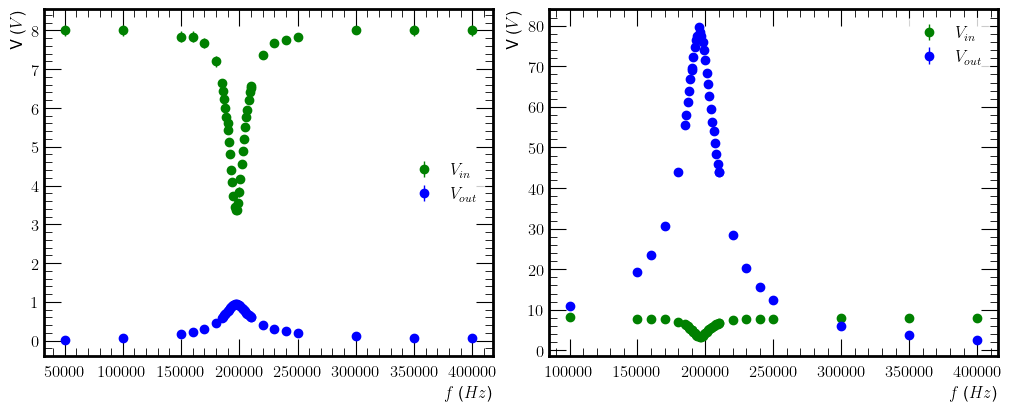

In [5]:
# Plot of collected data
fig, axA = plt.subplots(1,2, figsize=(10,4),constrained_layout = True, width_ratios=[1, 1])

axA[0].errorbar(fR, VinR, yerr=sVinR , label=r"$V_{in}$", fmt='go')
axA[0].errorbar(fR, VoutR, yerr=sVoutR, label=r"$V_{out}$" , fmt='bo')

axA[0].set_xlabel(r"$f$ ($Hz$)")
axA[0].set_ylabel(r"V ($V$)")

axA[0].legend(loc='center right')

axA[1].errorbar(fC, VinC, yerr=sVinC, label=r"$V_{in}$" , fmt='go')
axA[1].errorbar(fC, VoutC, yerr=sVoutC, label=r"$V_{out}$" , fmt='bo')

axA[1].set_xlabel(r"$f$ ($Hz$)")
axA[1].set_ylabel(r"V ($V$)")

axA[1].legend(loc='upper right')

plt.show()

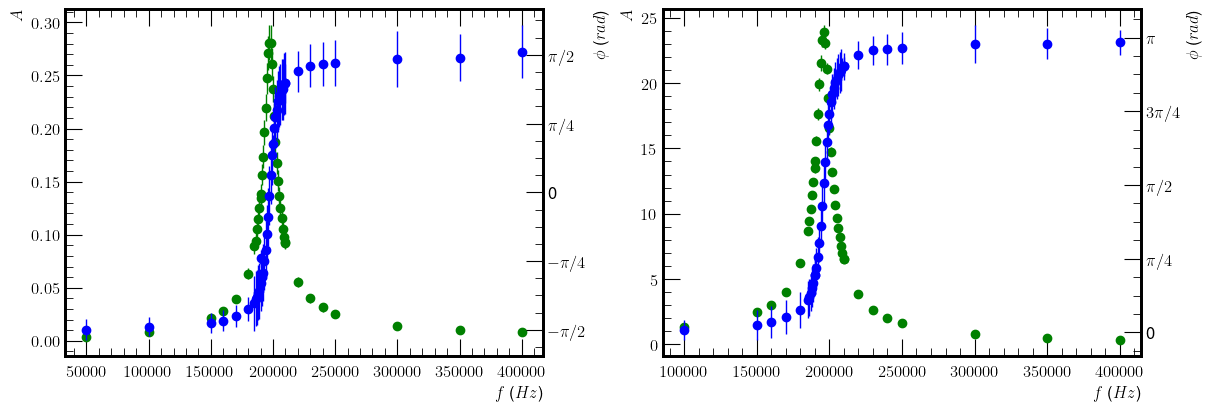

In [6]:
# Plot of collected data
fig, axA = plt.subplots(1,2, figsize=(12,4),constrained_layout = True, width_ratios=[1, 1])

axA[0].errorbar(fR, TfR, yerr=sTfR , fmt='go')
axF0 = axA[0].twinx()
axF0.errorbar(fR, phiR,  yerr= sphiR, fmt='bo')
axF0.set_yticks((-np.pi/2,-np.pi/4,0, np.pi/4, np.pi/2))
labels = axF0.set_yticklabels((r'$-\pi / 2$',r'$-\pi / 4$','0', r'$\pi / 4$', r'$\pi / 2$'))
axA[0].set_xlabel(r"$f$ ($Hz$)")
axA[0].set_ylabel(r"$A$")
axF0.set_ylabel(r"$\phi$ ($rad$)")


axA[1].errorbar(fC, TfC, yerr=sTfC , fmt='go')
axF1 = axA[1].twinx()
axF1.errorbar(fC, phiC,  yerr= sphiC, fmt='bo')
axF1.set_yticks((0,np.pi/4,np.pi/2, 3*np.pi/4, np.pi))
labels = axF1.set_yticklabels((r'0',r'$\pi / 4$',r'$\pi / 2$', r'$3 \pi / 4$', r'$\pi$'))
axA[1].set_xlabel(r"$f$ ($Hz$)")
axA[1].set_ylabel(r"$A$")
axF1.set_ylabel(r"$\phi$ ($rad$)")

plt.show()

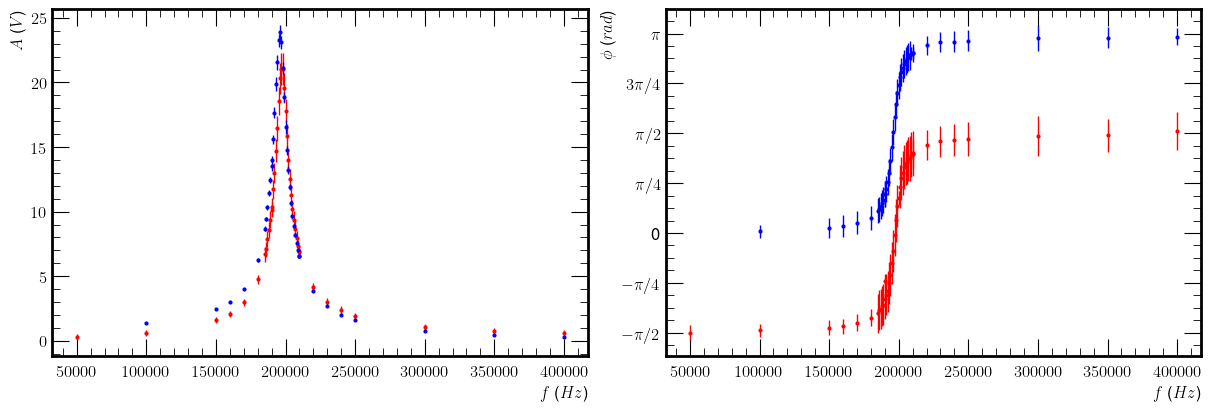

In [142]:
# Plot of collected data
fig, axA = plt.subplots(1,2, figsize=(12,4),constrained_layout = True, width_ratios=[1, 1])

axA[0].errorbar(fR, TfR*75, yerr=sTfR*75, fmt='ro', ms = 2)
axA[0].errorbar(fC, TfC, yerr=sTfC , fmt='bo', ms = 2)

axA[0].set_xlabel(r"$f$ ($Hz$)")
axA[0].set_ylabel(r"$A$ ($V$)")


axA[1].errorbar(fR, phiR,  yerr= sphiR, fmt='ro', ms = 2)
axA[1].errorbar(fC, phiC,  yerr= sphiC, fmt='bo', ms = 2)

axA[1].set_yticks((-np.pi/2,-np.pi/4,0,np.pi/4,np.pi/2, 3*np.pi/4, np.pi))
labels = axA[1].set_yticklabels((r'$-\pi / 2$',r'$-\pi / 4$',r'0',r'$\pi / 4$',r'$\pi / 2$', r'$3 \pi / 4$', r'$\pi$'))
axA[1].set_xlabel(r"$f$ ($Hz$)")
axA[1].set_ylabel(r"$\phi$ ($rad$)")

plt.show()

0.08379946073976519
0.04543603637921593
0.11571384195069827
0.28029885233058827
0.7382787789329205
1.6348125774289353
2.5817990509100133
4.2182075668110635
6.622166675788038
9.07325803829665
11.782853860702373
15.26908445643715


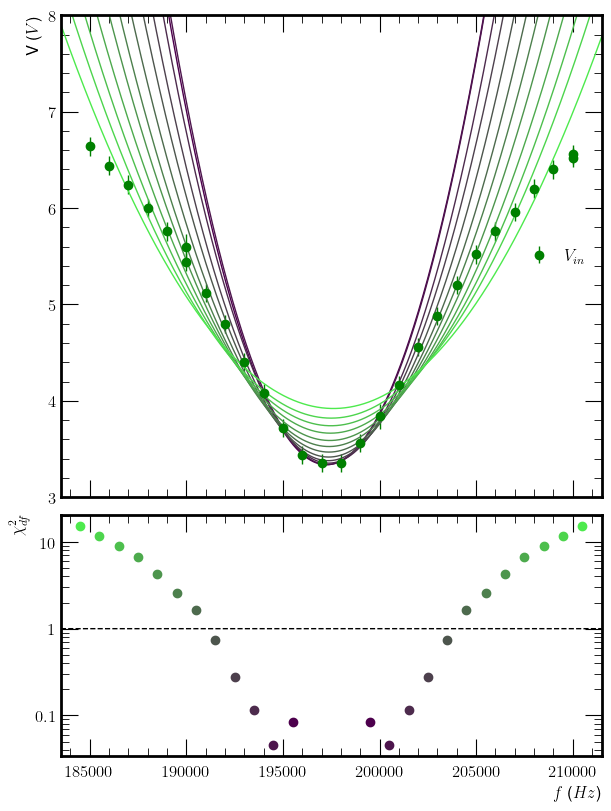

In [99]:
parpvaluelist = []
chi2parabole = []
h = 14
for i in range(2,h):
    parvalue, covparvalue = curve_fit(parabola, fR[fR>197500-i*1e3][fR[fR>197500-i*1e3] < 197500+i*1e3],VinR[fR>197500-i*1e3][fR[fR>197500-i*1e3] < 197500+i*1e3], method='lm' ,sigma=sVinR[fR>197500-i*1e3][fR[fR>197500-i*1e3] < 197500+i*1e3], absolute_sigma=True)
    parpvaluelist.append(parvalue)
    chi2parabole.append(np.sum(((VinR[fR>197500-i*1e3][fR[fR>197500-i*1e3] < 197500+i*1e3]-parabola(fR[fR>197500-i*1e3][fR[fR>197500-i*1e3] < 197500+i*1e3],*parvalue))/sVinR[fR>197500-i*1e3][fR[fR>197500-i*1e3] < 197500+i*1e3])**2)/(len(fR[fR>197500-i*1e3][fR[fR>197500-i*1e3] < 197500+i*1e3])-3))

    print(chi2parabole[i-2])

# Plot of collected data
fig, axA = plt.subplots(2,1, figsize=(6,8),sharex=True, constrained_layout = True, height_ratios = [2,1])

axA[0].errorbar(fR[fR>197500-h*1e3][fR[fR>197500-h*1e3] < 197500+h*1e3], VinR[fR>197500-h*1e3][fR[fR>197500-h*1e3] < 197500+h*1e3], yerr=sVinR[fR>197500-h*1e3][fR[fR>197500-h*1e3] < 197500+h*1e3] , label=r"$V_{in}$", fmt='go')

xfit = np.linspace(197500-h*1e3 , 197500+h*1e3 ,10000)

for i in range(len(parpvaluelist)):
    axA[0].plot(xfit, parabola(xfit, *parpvaluelist[i]), color=(0.3,i/len(parpvaluelist),0.3))

axA[0].set_ylabel(r"V ($V$)")

axA[0].set_xlim(197500-h*1e3,197500+h*1e3)
axA[0].set_ylim(3,8)


axA[0].legend(loc='center right')

for i in range(len(parpvaluelist)):
    axA[1].scatter(197500-(i+2)*1e3, chi2parabole[i], color=(0.3,i/len(parpvaluelist),0.3))
    axA[1].scatter(197500+(i+2)*1e3, chi2parabole[i], color=(0.3,i/len(parpvaluelist),0.3))

axA[1].plot(xfit, np.full(len(xfit),1), linestyle='--', color='black')


axA[1].semilogy()

axA[1].set_xlabel(r"$f$ ($Hz$)")
axA[1].set_ylabel(r"$\chi ^ 2 _{df}$")

plt.show()


0.08379946073976519
0.04543603637921593
0.11571384195069827
0.28029885233058827
0.7382787789329205


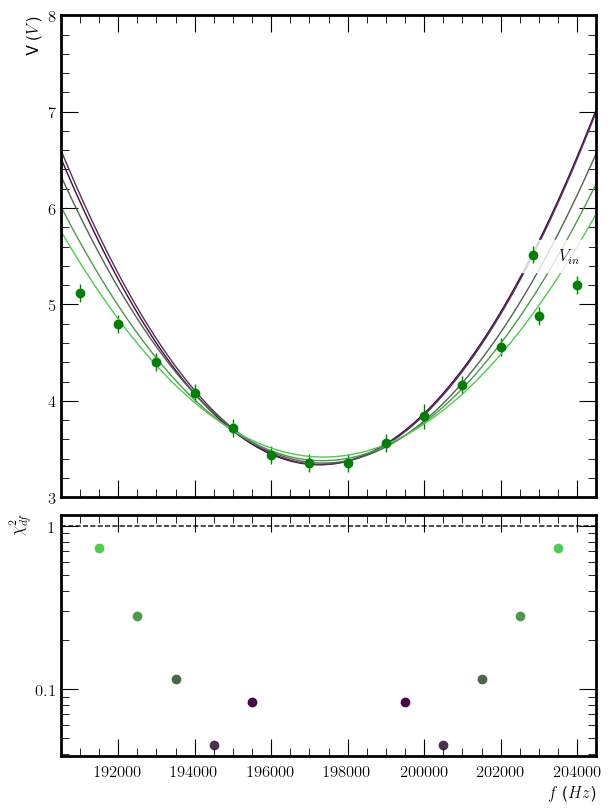

In [100]:
parpvaluelist = []
chi2parabole = []
h = 7
for i in range(2,h):
    parvalue, covparvalue = curve_fit(parabola, fR[fR>197500-i*1e3][fR[fR>197500-i*1e3] < 197500+i*1e3],VinR[fR>197500-i*1e3][fR[fR>197500-i*1e3] < 197500+i*1e3], method='lm' ,sigma=sVinR[fR>197500-i*1e3][fR[fR>197500-i*1e3] < 197500+i*1e3], absolute_sigma=True)
    parpvaluelist.append(parvalue)
    chi2parabole.append(np.sum(((VinR[fR>197500-i*1e3][fR[fR>197500-i*1e3] < 197500+i*1e3]-parabola(fR[fR>197500-i*1e3][fR[fR>197500-i*1e3] < 197500+i*1e3],*parvalue))/sVinR[fR>197500-i*1e3][fR[fR>197500-i*1e3] < 197500+i*1e3])**2)/(len(fR[fR>197500-i*1e3][fR[fR>197500-i*1e3] < 197500+i*1e3])-3))

    print(chi2parabole[i-2])

# Plot of collected data
fig, axA = plt.subplots(2,1, figsize=(6,8),sharex=True, constrained_layout = True, height_ratios = [2,1])

axA[0].errorbar(fR[fR>197500-h*1e3][fR[fR>197500-h*1e3] < 197500+h*1e3], VinR[fR>197500-h*1e3][fR[fR>197500-h*1e3] < 197500+h*1e3], yerr=sVinR[fR>197500-h*1e3][fR[fR>197500-h*1e3] < 197500+h*1e3] , label=r"$V_{in}$", fmt='go')

xfit = np.linspace(197500-h*1e3 , 197500+h*1e3 ,10000)

for i in range(len(parpvaluelist)):
    axA[0].plot(xfit, parabola(xfit, *parpvaluelist[i]), color=(0.3,i/len(parpvaluelist),0.3))

axA[0].set_ylabel(r"V ($V$)")

axA[0].set_xlim(197500-h*1e3,197500+h*1e3)
axA[0].set_ylim(3,8)


axA[0].legend(loc='center right')

for i in range(len(parpvaluelist)):
    axA[1].scatter(197500-(i+2)*1e3, chi2parabole[i], color=(0.3,i/len(parpvaluelist),0.3))
    axA[1].scatter(197500+(i+2)*1e3, chi2parabole[i], color=(0.3,i/len(parpvaluelist),0.3))

axA[1].plot(xfit, np.full(len(xfit),1), linestyle='--', color='black')


axA[1].semilogy()

axA[1].set_xlabel(r"$f$ ($Hz$)")
axA[1].set_ylabel(r"$\chi ^ 2 _{df}$")

plt.show()


In [101]:
VinVuoto = 8 #V
sVinVuoto = np.sqrt((0.03*8/(24**0.5))**2+(2/(25*24**0.5))) # Assumo triangolare

Rg = 48.4
sRg = 0.7

parvalue, covpar = curve_fit(parabola, fR[fR>197500-6e3][fR[fR>197500-6e3] < 197500+6e3],VinR[fR>197500-6e3][fR[fR>197500-6e3] < 197500+6e3], method='lm' ,sigma=sVinR[fR>197500-6e3][fR[fR>197500-6e3] < 197500+6e3], absolute_sigma=True)

a, b, c = parvalue
sa, sb, sc = np.sqrt(np.diag(covpar))
sab, sbc = np.diag(covpar, 1)
sac = np.diag(covpar,2)[0]

fmin = -b/(2*a)
sfmin = fmin * np.sqrt((sb/b)**2+(sa/a)**2)

Vmin = parabola(fmin, *parvalue)
sVmin = np.sqrt(((2*a*fmin+b)*sfmin)**2+(fmin**2*sa)**2+(fmin*sb)**2+sc**2+2*fmin**3*sab+2*fmin*sbc+2*fmin**2*sac)

Rt = Rg/(1-Vmin/VinVuoto)
sRt = np.sqrt((sRg/(1-Vmin/VinVuoto))+(Rg*sVmin/((1-Vmin/VinVuoto)**2 * VinVuoto))**2 + (Rg*Vmin*sVmin/((1-Vmin/VinVuoto)**2 * VinVuoto))**2)

print("Rt = ", round(Rt), " +/- ", round(sRt), "Ohm")

Rt =  84  +/-  3 Ohm
Ipotetico R_Circuito =  36 +/- 3 Ohm


In [127]:
f = []
sf = []
q = []
sq = []
cqf = []

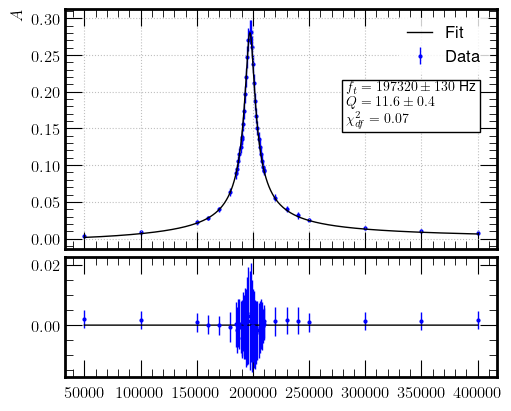

In [128]:
vAR, cvAR = curve_fit(A_R, fR, TfR, p0=[36, 196850, 0.3], method='lm' ,sigma=sTfR, absolute_sigma=True)

rAR = TfR - A_R(fR, *vAR)
df = len(fR)-3
chi2AR = np.sum((rAR/sTfR)**2)/df

q.append(vAR[0])
sq.append(np.sqrt(cvAR[0,0]))
f.append(vAR[1])
sf.append(np.sqrt(cvAR[1,1]))
cqf.append(cvAR[1,0])

fig, ax = plt.subplots(2,1, figsize=(5,4),sharex=True, constrained_layout = True, height_ratios = [2,1])

xfit = np.linspace(min(fR)-100, max(fR) + 100, 4000)

ax[0].errorbar(fR,TfR, yerr=sTfR, label='Data', fmt='bo', ms=2, zorder = -1)
ax[0].plot(xfit, A_R(xfit, *vAR), label='Fit', linestyle = '-' ,color = 'k')

ax[0].legend(loc='upper right')
ax[0].set_ylabel(r'$A$')

textstr = '\n'.join((
    r'$f_t = %.f \pm %.f$ Hz' % (round(vAR[1],-1), round(np.sqrt(cvAR[1,1]),-1)),
    r'$Q = %.1f \pm %.1f$ ' % (vAR[0], np.sqrt(cvAR[0,0])),
    r'$\chi^2_{df} = %.2f $' % (chi2AR)))

# Posizionamento del box nell'angolo in alto a sinistra
props = dict(boxstyle='square', facecolor='white', alpha=1)
ax[0].text(0.65, 0.7, textstr, transform=ax[0].transAxes, fontsize=10,
           verticalalignment='top', bbox=props)

ax[0].grid(True)


ax[1].errorbar(fR,rAR, yerr=sTfR, label='Data', fmt='bo', ms=2)
ax[1].plot(xfit, np.full(len(xfit),0), color="k")

plt.show()

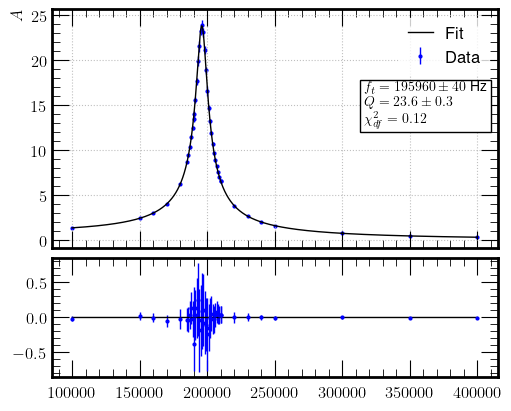

In [129]:
vAC, cvAC = curve_fit(A_C, fC, TfC, p0=[1, 196850, 1], method='lm' ,sigma=sTfC, absolute_sigma=True)

rAC = TfC - A_C(fC, *vAC)
df = len(fC)-3
chi2AC = np.sum((rAC/sTfC)**2)/df

q.append(vAC[0])
sq.append(np.sqrt(cvAC[0,0]))
f.append(vAC[1])
sf.append(np.sqrt(cvAC[1,1]))
cqf.append(cvAC[1,0])

fig, ax = plt.subplots(2,1, figsize=(5,4),sharex=True, constrained_layout = True, height_ratios = [2,1])

xfit = np.linspace(min(fC)-100, max(fC) + 100, 4000)

ax[0].errorbar(fC,TfC, yerr=sTfC, label='Data', fmt='bo', ms=2, zorder = -1)
ax[0].plot(xfit, A_C(xfit, *vAC), label='Fit', linestyle = '-' ,color = 'k')

ax[0].legend(loc='upper right')
ax[0].set_ylabel(r'$A$')

textstr = '\n'.join((
    r'$f_t = %.f \pm %.f$ Hz' % (round(vAC[1],-1), round(np.sqrt(cvAC[1,1]),-1)),
    r'$Q = %.1f \pm %.1f$ ' % (vAC[0], np.sqrt(cvAC[0,0])),
    r'$\chi^2_{df} = %.2f $' % (chi2AC)))

# Posizionamento del box nell'angolo in alto a sinistra
props = dict(boxstyle='square', facecolor='white', alpha=1)
ax[0].text(0.7, 0.7, textstr, transform=ax[0].transAxes, fontsize=10,
           verticalalignment='top', bbox=props)

ax[0].grid(True)


ax[1].errorbar(fC,rAC, yerr=sTfC, label='Data', fmt='bo', ms=2)
ax[1].plot(xfit, np.full(len(xfit),0), color="k")

plt.show()

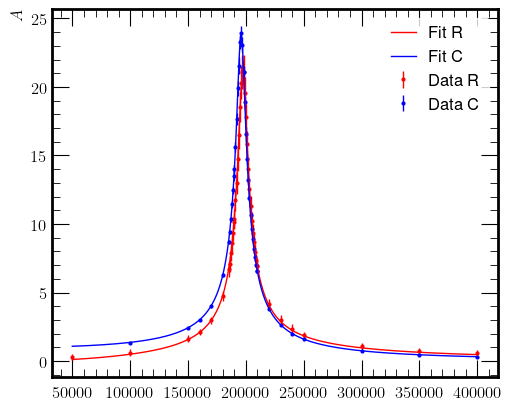

In [130]:
fig, ax = plt.subplots(1,1, figsize=(5,4),constrained_layout = True)

xfit = np.linspace(min(fR)-100, max(fC) + 100, 4000)

ax.plot(xfit, A_R(xfit, *vAR)*75, label='Fit R', linestyle = '-' ,color = 'r')
ax.errorbar(fR,TfR*75, yerr=sTfR*75, label='Data R', fmt='ro', ms=2, zorder = -1)

ax.plot(xfit, A_C(xfit, *vAC), label='Fit C', linestyle = '-' ,color = 'b')
ax.errorbar(fC,TfC, yerr=sTfC, label='Data C', fmt='bo', ms=2, zorder = -1)

ax.legend(loc='upper right')
ax.set_ylabel(r'$A$')

plt.show()

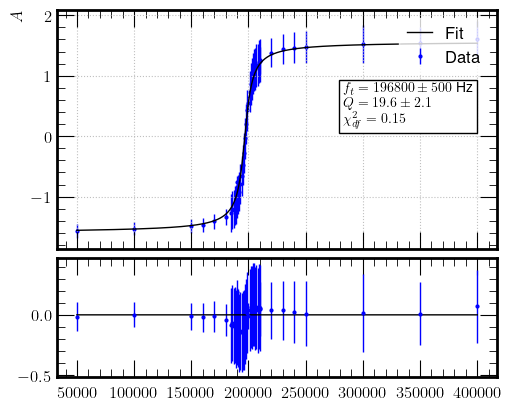

In [131]:
vphiR, cvphiR = curve_fit(phi_R, fR, phiR, p0=[12, 196850], method='lm' ,sigma=sphiR, absolute_sigma=True)

rphiR = phiR - phi_R(fR, *vphiR)
df = len(fR)-2
chi2phiR = np.sum((rphiR/sphiR)**2)/df

q.append(vphiR[0])
sq.append(np.sqrt(cvphiR[0,0]))
f.append(vphiR[1])
sf.append(np.sqrt(cvphiR[1,1]))
cqf.append(cvphiR[1,0])


fig, ax = plt.subplots(2,1, figsize=(5,4),sharex=True, constrained_layout = True, height_ratios = [2,1])

xfit = np.linspace(min(fR)-100, max(fR) + 100, 4000)

ax[0].errorbar(fR,phiR, yerr=sphiR, label='Data', fmt='bo', ms=2, zorder = -1)
ax[0].plot(xfit, phi_R(xfit, *vphiR), label='Fit', linestyle = '-' ,color = 'k')

ax[0].legend(loc='upper right')
ax[0].set_ylabel(r'$A$')

textstr = '\n'.join((
    r'$f_t = %.f \pm %.f$ Hz' % (round(vphiR[1],-2), round(np.sqrt(cvphiR[1,1]),-2)),
    r'$Q = %.1f \pm %.1f$ ' % (vphiR[0], np.sqrt(cvphiR[0,0])),
    r'$\chi^2_{df} = %.2f $' % (chi2phiR)))

# Posizionamento del box nell'angolo in alto a sinistra
props = dict(boxstyle='square', facecolor='white', alpha=1)
ax[0].text(0.65, 0.7, textstr, transform=ax[0].transAxes, fontsize=10,
           verticalalignment='top', bbox=props)

ax[0].grid(True)


ax[1].errorbar(fR,rphiR, yerr=sphiR, label='Data', fmt='bo', ms=2)
ax[1].plot(xfit, np.full(len(xfit),0), color="k")

plt.show()

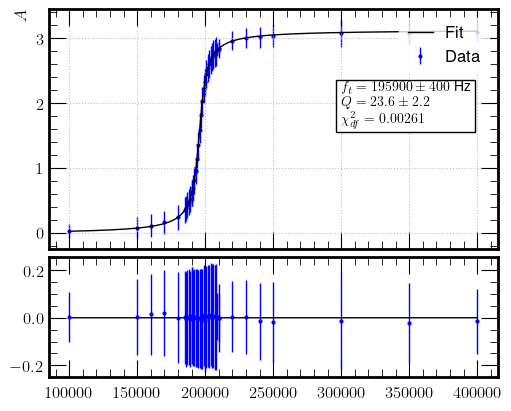

In [132]:
vphiC, cvphiC = curve_fit(phi_C, fC, phiC, p0=[12, 196850, np.pi/2], method='lm' ,sigma=sphiC, absolute_sigma=True)

rphiC = phiC - phi_C(fC, *vphiC)
df = len(fC)-2
chi2phiC = np.sum((rphiC/sphiC)**2)/df

q.append(vphiC[0])
sq.append(np.sqrt(cvphiC[0,0]))
f.append(vphiC[1])
sf.append(np.sqrt(cvphiC[1,1]))
cqf.append(cvphiC[1,0])

fig, ax = plt.subplots(2,1, figsize=(5,4),sharex=True, constrained_layout = True, height_ratios = [2,1])

xfit = np.linspace(min(fC)-100, max(fC) + 100, 4000)

ax[0].errorbar(fC,phiC, yerr=sphiC, label='Data', fmt='bo', ms=2, zorder = -1)
ax[0].plot(xfit, phi_C(xfit, *vphiC), label='Fit', linestyle = '-' ,color = 'k')

ax[0].legend(loc='upper right')
ax[0].set_ylabel(r'$A$')

textstr = '\n'.join((
    r'$f_t = %.f \pm %.f$ Hz' % (round(vphiC[1],-2), round(np.sqrt(cvphiC[1,1]),-2)),
    r'$Q = %.1f \pm %.1f$ ' % (vphiC[0], np.sqrt(cvphiC[0,0])),
    r'$\chi^2_{df} = %.5f $' % (chi2phiC)))

# Posizionamento del box nell'angolo in alto a sinistra
props = dict(boxstyle='square', facecolor='white', alpha=1)
ax[0].text(0.65, 0.7, textstr, transform=ax[0].transAxes, fontsize=10,
           verticalalignment='top', bbox=props)

ax[0].grid(True)


ax[1].errorbar(fC,rphiC, yerr=sphiC, label='Data', fmt='bo', ms=2)
ax[1].plot(xfit, np.full(len(xfit),0), color="k")

plt.show()

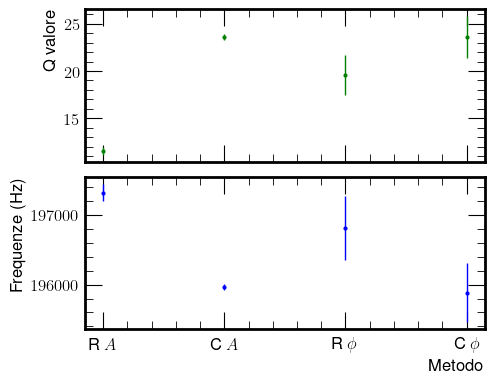

In [134]:
fig, ax = plt.subplots(2,1, figsize=(5,4), sharex = True)

ax[0].errorbar([0,1,2,3], q,  yerr= sq , fmt='go', ms = 2)

ax[1].errorbar([0,1,2,3], f,  yerr= sf , fmt='bo', ms = 2)


ax[1].set_xticks([0,1,2,3])
labels = ax[1].set_xticklabels((r"R $A$", r"C $A$", r"R $\phi$", r"C $\phi$"))

ax[1].set_xlabel("Metodo")
ax[0].set_ylabel("Q valore")
ax[1].set_ylabel("Frequenze (Hz)")

plt.show()

In [135]:
# Stime di R e L con C fisso
Cfisso = 1.09*10**-9
sCfisso = 0.08*10**-9

f = np.array(f)
sf = np.array(sf)
q = np.array(q)
sq = np.array(sq)
cov = np.array(cqf)

L = 1/(f**2*Cfisso*4*np.pi**2)
sL = L * np.sqrt((sf/f)**2+(sCfisso/Cfisso)**2)

R = 1/(f*q*Cfisso*2*np.pi)
sR = R * np.sqrt((sf/f)**2 + (sCfisso/Cfisso)**2 + (sq/q)**2 + 2 * cov/(q*f))

for i in range(4):
    print("L: ", L[i], "+/-", sL[i])
for i in range(4):
    print("R: ", R[i], "+/-", sR[i])

L:  0.0005968810297507194 +/- 4.3809419992716115e-05
L:  0.0006051650046970724 +/- 4.441597601475153e-05
L:  0.0005999691722049443 +/- 4.405625842292891e-05
L:  0.0006056404733097701 +/- 4.4470286313604125e-05
R:  63.991711295136696 +/- 5.257623092819761
R:  31.59929502784198 +/- 2.3501842875214956
R:  37.897632866913334 +/- 4.908654833110255
R:  31.61107408743211 +/- 3.743284717981475


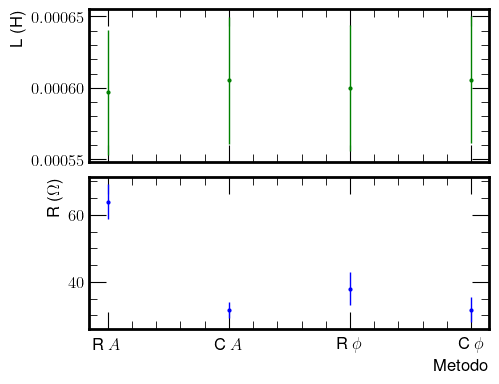

In [137]:
fig, ax = plt.subplots(2,1, figsize=(5,4), sharex = True)

ax[0].errorbar([0,1,2,3], L,  yerr= sL , fmt='go', ms = 2)

ax[1].errorbar([0,1,2,3], R,  yerr= sR , fmt='bo', ms = 2)


ax[1].set_xticks([0,1,2,3])
labels = ax[1].set_xticklabels((r"R $A$", r"C $A$", r"R $\phi$", r"C $\phi$"))

ax[1].set_xlabel("Metodo")
ax[0].set_ylabel("L (H)")
ax[1].set_ylabel(r"R ($\Omega$)")

plt.show()

In [154]:
diff_phi = []
intersect = np.intersect1d(fC, fR, assume_unique=False, return_indices=False)
for i in intersect:
    diff_phi.append(phiC[fC == i]-phiR[fR == i])
print(intersect)

ValueError: ('Lengths must match to compare', (40,), (38,))

In [ ]:
# Plot of collected data
fig, axA = plt.subplots(2,1, figsize=(8,6), sharex=True, constrained_layout = True, height_ratios=[2, 1])

axA[0].errorbar(fR, phiR,  yerr= sphiR, fmt='ro', ms = 2)
axA[0].errorbar(fC, phiC,  yerr= sphiC, fmt='bo', ms = 2)

axA[0].set_yticks((-np.pi/2,-np.pi/4,0,np.pi/4,np.pi/2, 3*np.pi/4, np.pi))
labels = axA[0].set_yticklabels((r'$-\pi / 2$',r'$-\pi / 4$',r'0',r'$\pi / 4$',r'$\pi / 2$', r'$3 \pi / 4$', r'$\pi$'))
axA[0].set_xlabel(r"$f$ ($Hz$)")
axA[0].set_ylabel(r"$\phi$ ($rad$)")

axA[1].errorbar(fR, phiR,  yerr= sphiR, fmt='ro', ms = 2)

plt.show()